In [1]:
import os, sys, glob, shutil, json
import cv2

from PIL import Image
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from tensorboardX import SummaryWriter   # tensorboard
import torchvision.transforms as transforms


print(torch.__version__)
print(torch.cuda.is_available())

1.7.0+cu101
True


In [2]:
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label 
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # 原始SVHN中类别10为填充的数字X, 最多字符为6
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl)  + (4 - len(lbl)) * [10]
        
        return img, torch.from_numpy(np.array(lbl[:4]))

    def __len__(self):
        return len(self.img_path)


train_path = glob.glob('../input/mchar_train/*.png')
train_path.sort()
train_json = json.load(open('../input/mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]

val_path = glob.glob('../input/mchar_val/*.png')
val_path.sort()
val_json = json.load(open('../input/mchar_val.json'))
val_label = [val_json[x]['label'] for x in val_json]

# BATCH_SIZE = 10
BATCH_SIZE = 1000

train_loader = torch.utils.data.DataLoader(
        SVHNDataset(train_path, train_label,
                   transforms.Compose([
                       transforms.Resize((64, 128)),
                       transforms.ColorJitter(0.3, 0.3, 0.2),
                       transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=BATCH_SIZE, # 每批样本个数
    shuffle=True, # 是否打乱顺序
    num_workers=10, # 读取的线程个数
)

    
val_loader = torch.utils.data.DataLoader(
    SVHNDataset(val_path, val_label,
                    transforms.Compose([
                       transforms.Resize((64, 128)),
                    #    transforms.ColorJitter(0.3, 0.3, 0.2),
                    #    transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=10, 
)

In [3]:
# 定义模型
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()
        # CNN提取特征模块
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),  
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(), 
            nn.MaxPool2d(2),
        )
        # 
        self.fc1 = nn.Linear(32*3*7, 11)
        self.fc2 = nn.Linear(32*3*7, 11)
        self.fc3 = nn.Linear(32*3*7, 11)
        self.fc4 = nn.Linear(32*3*7, 11)
    
    def forward(self, img):        
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        return c1, c2, c3, c4

# model = SVHN_Model1()
model = SVHN_Model1().cuda()
# 损失函数
criterion = nn.CrossEntropyLoss(size_average=False)
# 优化器
optimizer = torch.optim.Adam(model.parameters(), 0.001)
best_loss = 1000.0

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [4]:
def train(train_loader, model, criterion, optimizer, epoch):
    # 切换模型为训练模式
    model.train()
    train_loss = []

    for (data, label) in tqdm(train_loader):
        data = data.cuda()
        label = label.cuda()
        c0, c1, c2, c3 = model(data)
        loss = criterion(c0, label[:, 0]) + \
                criterion(c1, label[:, 1]) + \
                criterion(c2, label[:, 2]) + \
                criterion(c3, label[:, 3])
        loss /= (4*BATCH_SIZE)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    return np.mean(train_loss)


def validate(val_loader, model, criterion):
    # 切换模型为预测模型
    model.eval()
    val_loss = []
    val_predict = []

    # 不记录模型梯度信息
    with torch.no_grad():
        for (data, label) in tqdm(val_loader):
            data = data.cuda()
            label = label.cuda()
            c0, c1, c2, c3 = model(data)
            # print(c0.shape)
            loss = criterion(c0, label[:, 0]) + \
                    criterion(c1, label[:, 1]) + \
                    criterion(c2, label[:, 2]) + \
                    criterion(c3, label[:, 3]) 
            loss /= (4*BATCH_SIZE)
            val_loss.append(loss.item())
            
            # calculate validation accuracy
            output = np.concatenate([
                c0.data.cpu().numpy(),
                c1.data.cpu().numpy(),
                c2.data.cpu().numpy(),
                c3.data.cpu().numpy()], axis=1)# output: shape(batch, 44)
            val_predict.append(output)        
        val_predict = np.vstack(val_predict)
        
        val_predict = np.vstack([
            val_predict[:, :11].argmax(1),
            val_predict[:, 11:22].argmax(1),
            val_predict[:, 22:33].argmax(1),
            val_predict[:, 33:44].argmax(1)]).T
        val_predict_label = list()
        for x in val_predict:
            val_predict_label.append(''.join(map(str, x[x!=10])))
        val_label = [''.join(map(str, x)) for x in val_loader.dataset.img_label]
        val_acc = np.mean(np.array(val_predict_label) == np.array(val_label))
    return np.mean(val_loss), val_acc

In [11]:
# load model
model.load_state_dict(torch.load('model.pt'))

train_loss_plot = list()
val_loss_plot = list()
val_acc_plot = list()

# writer = SummaryWriter('log')
writer = SummaryWriter()

from datetime import datetime
now = datetime.now()

for epoch in range(20):
    print('\nEpoch: ', epoch)

    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss, val_acc = validate(val_loader, model, criterion)# val_predict: shape(10000, 44)

    
    # 记录下验证集精度
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), './model.pt')
    
    train_loss_plot.append(train_loss)
    val_loss_plot.append(val_loss)
    val_acc_plot.append(val_acc)
    writer.add_scalar('Loss/train', float(train_loss), epoch)
    writer.add_scalar('Loss/validation', float(val_loss), epoch)
    writer.add_scalar('val_acc', float(val_acc), epoch)

writer.close()

print("\nruning time:", datetime.now() - now)

  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  0


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  1


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  2


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  3


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  4


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  5


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  6


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  7


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  8


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  9


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  10


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  11


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  12


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  13


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  14


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  15


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  16


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  17


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  18


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  19


100%|██████████| 10/10 [00:02<00:00,  4.60it/s]



runing time: 0:02:52.392319


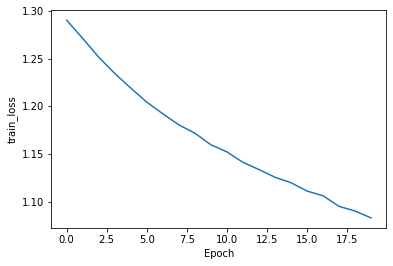

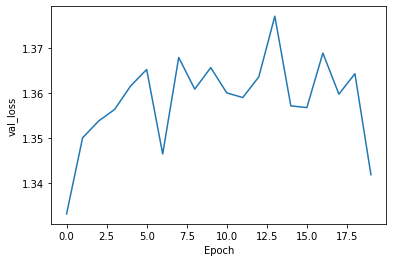

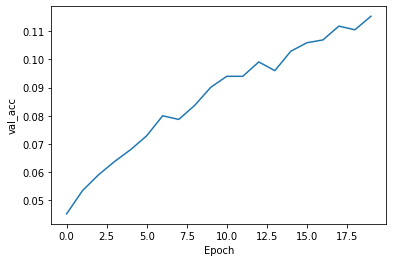


train_loss: [1.2905000487963358, 1.2714127779006958, 1.2517240722974141, 1.2346606771151225, 1.2192785223325093, 1.2045563062032063, 1.192305338382721, 1.1806952675183615, 1.171991801261902, 1.1597979664802551, 1.1523356477419535, 1.1414027412732441, 1.1338372230529785, 1.1257119019826254, 1.119976246356964, 1.1112316648165386, 1.1063151876131694, 1.0951775034268698, 1.090238920847575, 1.0830233256022135]

val_loss: [1.333075714111328, 1.3500443935394286, 1.3537837862968445, 1.356377363204956, 1.3616071462631225, 1.3652818322181701, 1.3464329242706299, 1.3679600715637208, 1.3608930945396422, 1.3656927824020386, 1.3600555777549743, 1.3590218663215636, 1.363632583618164, 1.3771476745605469, 1.3571695566177369, 1.3567809343338013, 1.3689332604408264, 1.3597761869430542, 1.3643288612365723, 1.3418049216270447]

val_acc: [0.0452, 0.0535, 0.0591, 0.0638, 0.068, 0.0729, 0.08, 0.0787, 0.0837, 0.0901, 0.094, 0.094, 0.0991, 0.096, 0.1029, 0.1059, 0.1069, 0.1118, 0.1105, 0.1153]


In [12]:
plt.plot(train_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("train_loss")
plt.show()

plt.plot(val_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("val_loss")
plt.show()

plt.plot(val_acc_plot)
plt.xlabel("Epoch")
plt.ylabel("val_acc")
plt.show()

print("\ntrain_loss:", train_loss_plot)
print("\nval_loss:", val_loss_plot)
print("\nval_acc:", val_acc_plot)